In [34]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
import sys
import matplotlib
import numpy
import os
if 'DISPLAY' not in os.environ:
    matplotlib.use('Agg')
    show_image=False
else:
    show_image=True
from matplotlib import pyplot as plt
from torchvision import utils

In [35]:
def imshow(inp, file_name='NoName.png', save=False, title=None):
    """Imshow for Tensor."""
    fig = plt.figure(figsize=(5, 5))
    inp = transforms.ToPILImage()(inp)
    plt.imshow(inp)
    plt.savefig(file_name)
    if show_image:
        plt.show()
    plt.gcf().clear()

In [36]:
batch_size = 100
z_size=2
hidden_size=64
img_size=32
niter=100
epsilon=0.1
G_lr = D_lr = 5e-3
use_cuda=torch.cuda.is_available()

In [37]:
root = './data'
download = True
trans = transforms.Compose([
#     transforms.Scale(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
data_set = dset.CIFAR10(
    root=root, train=True, transform=trans, download=download)
kwargs = {}
D_loader = torch.utils.data.DataLoader(
    dataset=data_set, batch_size=batch_size, shuffle=True)
G_loader = torch.utils.data.DataLoader(
    dataset=data_set, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [52]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_size,hidden_size*8,4,2,1),
            nn.BatchNorm2d(hidden_size*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_size*8,hidden_size*4,4,2,1),
            nn.BatchNorm2d(hidden_size*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_size*4,hidden_size*2,4,2,1),
            nn.BatchNorm2d(hidden_size*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_size*2,hidden_size,4,2,1),
            nn.BatchNorm2d(hidden_size*1),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_size,3,4,2,1),
            nn.Tanh(),
        )
    def forward(self, x):
        x = x.view(x.size()[0], z_size, 1, 1)
        out = self.model(x)
        out = out.view(x.size()[0], 3, img_size,img_size)
        return out

In [53]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.model = nn.Sequential(
            # 1*3
            nn.Conv2d(3,hidden_size,4,2,1),
            nn.BatchNorm2d(hidden_size),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(hidden_size,hidden_size*2,4,2,1),
            nn.BatchNorm2d(hidden_size*2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(hidden_size*2,hidden_size*4,4,2,1),
            nn.BatchNorm2d(hidden_size*4),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(hidden_size*4,hidden_size*8,4,2,1),
        )
        self.linear=nn.Sequential(
            nn.Linear(hidden_size*8*2*2,100)
        )
    def forward(self, x):
        out = self.model(x.view(x.size(0), 3, img_size, img_size))
        print(out.size())
        out=out.view(x.size()[0],hidden_size*8*2*2)
        out=self.linear(out)
        return out

In [54]:
one = torch.FloatTensor([1])
noise_holder=torch.FloatTensor(batch_size, z_size, 1, 1)
input_holder = torch.FloatTensor(batch_size, 1, img_size, img_size)
if use_cuda:
    one=one.cuda()
    noise_holder=noise_holder.cuda()
    input_holder=input_holder.cuda()
mone = one * -1

In [55]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [56]:
def sinkhorn_loss(x, y, epsilon, n, niter):
    """
	Given two emprical measures with n points each with locations x and y
	outputs an approximation of the OT cost with regularization parameter epsilon
	niter is the max. number of steps in sinkhorn loop
	"""
    # The Sinkhorn algorithm takes as input three variables :
    C = cost_matrix(x, y)/n  # Wasserstein cost function

    # both marginals are fixed with equal weights
    if use_cuda:
        mu = Variable(
            1. / n * torch.cuda.FloatTensor(n).fill_(1), requires_grad=False)
        nu = Variable(
            1. / n * torch.cuda.FloatTensor(n).fill_(1), requires_grad=False)
    else:
        mu = Variable(
            1. / n * torch.FloatTensor(n).fill_(1), requires_grad=False)
        nu = Variable(
            1. / n * torch.FloatTensor(n).fill_(1), requires_grad=False)

    # Parameters of the Sinkhorn algorithm.
    rho = 1  #(.5) **2          # unbalanced transport
    tau = -.8  # nesterov-like acceleration
    lam = rho / (rho + epsilon)  # Update exponent
    thresh = 10**(-1)  # stopping criterion

    # Elementary operations .....................................................................
    def ave(u, u1):
        "Barycenter subroutine, used by kinetic acceleration through extrapolation."
        return tau * u + (1 - tau) * u1

    def M(u, v):
        "Modified cost for logarithmic updates"
        "$M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$"
        return (-C + u.unsqueeze(1) + v.unsqueeze(0)) / epsilon

    def lse(A):
        "log-sum-exp"
        return torch.log(torch.exp(A).sum(1, keepdim=True) +
                         1e-6)  # add 10^-6 to prevent NaN

    # Actual Sinkhorn loop ......................................................................
    u, v, err = 0. * mu, 0. * nu, 0.
    actual_nits = 0  # to check if algorithm terminates because of threshold or max iterations reached

    for i in range(niter):
        u1 = u  # useful to check the update
        u = epsilon * (torch.log(mu) - lse(M(u, v)).squeeze()) + u
        v = epsilon * (torch.log(nu) - lse(M(u, v).t()).squeeze()) + v
        # accelerated unbalanced iterations
        #u = ave( u, lam * ( epsilon * ( torch.log(mu.unsqueeze(1)) - lse(M(u,v))   ) + u ) )
        #v = ave( v, lam * ( epsilon * ( torch.log(nu.unsqueeze(1)) - lse(M(u,v).t()) ) + v ) )
        err = (u - u1).abs().sum()

        actual_nits += 1
        if (err < thresh).data.cpu().numpy():
            break
    U, V = u, v
    pi = torch.exp(M(U, V))  # Transport plan pi = diag(a)*K*diag(b)
    cost = torch.sum(pi * C)  # Sinkhorn cost

    return cost


def cost_matrix(x, y, p=2):
    "Returns the matrix of $|x_i-y_j|^p$."
    x_col = x.unsqueeze(1)
    y_lin = y.unsqueeze(0)
    c = torch.sum((torch.abs(x_col - y_lin))**p, 2)
    return c

  0%|          | 0/10000 [00:00<?, ?it/s]

Generator (
  (model): Sequential (
    (0): ConvTranspose2d(2, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU (inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU (inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU (inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU (inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh ()
  )
)
torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


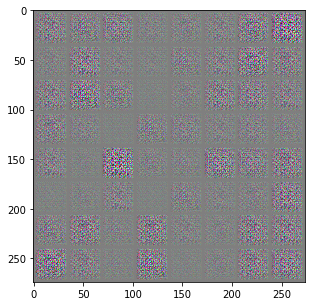

  0%|          | 1/10000 [00:04<12:34:03,  4.52s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 2/10000 [00:07<10:49:04,  3.90s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 3/10000 [00:10<10:03:50,  3.62s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 4/10000 [00:13<9:35:43,  3.46s/it] 

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 5/10000 [00:17<9:48:23,  3.53s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 6/10000 [00:21<10:07:57,  3.65s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 7/10000 [00:25<9:55:13,  3.57s/it] 

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 8/10000 [00:29<10:14:57,  3.69s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 9/10000 [00:48<14:59:05,  5.40s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 10/10000 [01:06<18:30:47,  6.67s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 11/10000 [01:15<19:04:57,  6.88s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 12/10000 [01:20<18:40:47,  6.73s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 13/10000 [01:27<18:44:43,  6.76s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 14/10000 [01:31<18:08:37,  6.54s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 15/10000 [01:44<19:21:15,  6.98s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 16/10000 [01:49<18:57:39,  6.84s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 17/10000 [01:54<18:44:48,  6.76s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 18/10000 [01:59<18:20:26,  6.61s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 19/10000 [02:02<17:52:39,  6.45s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 20/10000 [02:06<17:33:34,  6.33s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 21/10000 [02:10<17:15:17,  6.22s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 22/10000 [02:14<16:55:26,  6.11s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 23/10000 [02:17<16:33:33,  5.98s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 24/10000 [02:20<16:14:21,  5.86s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 25/10000 [02:24<16:02:09,  5.79s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 26/10000 [02:28<15:50:55,  5.72s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 27/10000 [02:32<15:39:33,  5.65s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 28/10000 [02:36<15:26:15,  5.57s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 29/10000 [02:39<15:13:22,  5.50s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 30/10000 [02:42<15:00:28,  5.42s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 31/10000 [02:45<14:47:32,  5.34s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 32/10000 [02:49<14:38:32,  5.29s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 33/10000 [02:52<14:30:04,  5.24s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 34/10000 [02:57<14:25:39,  5.21s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 35/10000 [03:06<14:42:54,  5.32s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 36/10000 [03:11<14:44:44,  5.33s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 37/10000 [03:19<14:54:52,  5.39s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 38/10000 [03:25<14:59:26,  5.42s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 39/10000 [03:32<15:04:15,  5.45s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 40/10000 [03:39<15:12:19,  5.50s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 41/10000 [03:47<15:20:51,  5.55s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 42/10000 [03:54<15:26:03,  5.58s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 43/10000 [04:00<15:29:23,  5.60s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 44/10000 [04:07<15:35:12,  5.64s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 45/10000 [04:15<15:41:14,  5.67s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 46/10000 [04:22<15:46:44,  5.71s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 47/10000 [04:29<15:51:35,  5.74s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 48/10000 [04:36<15:54:57,  5.76s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 49/10000 [04:43<15:58:20,  5.78s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  0%|          | 50/10000 [04:50<16:02:46,  5.81s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 51/10000 [04:57<16:05:45,  5.82s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 52/10000 [05:03<16:07:29,  5.84s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 53/10000 [05:09<16:09:20,  5.85s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 54/10000 [05:16<16:12:26,  5.87s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 55/10000 [05:24<16:16:35,  5.89s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 56/10000 [05:30<16:18:53,  5.91s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 57/10000 [05:37<16:19:58,  5.91s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 58/10000 [05:43<16:20:44,  5.92s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 59/10000 [05:50<16:23:20,  5.94s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 60/10000 [05:57<16:25:50,  5.95s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 61/10000 [06:03<16:27:36,  5.96s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 62/10000 [06:10<16:29:43,  5.98s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 63/10000 [06:18<16:33:53,  6.00s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 64/10000 [06:26<16:41:06,  6.05s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 65/10000 [06:35<16:46:15,  6.08s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 66/10000 [06:40<16:45:48,  6.07s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 67/10000 [06:44<16:39:59,  6.04s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 68/10000 [06:49<16:36:09,  6.02s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 69/10000 [06:54<16:33:56,  6.01s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 70/10000 [06:59<16:31:36,  5.99s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 71/10000 [07:07<16:35:29,  6.02s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 72/10000 [07:16<16:43:05,  6.06s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 73/10000 [07:27<16:53:42,  6.13s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 74/10000 [07:38<17:04:59,  6.20s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 75/10000 [07:49<17:15:08,  6.26s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 76/10000 [08:00<17:24:51,  6.32s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 77/10000 [08:10<17:32:27,  6.36s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 78/10000 [08:18<17:37:26,  6.39s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 79/10000 [08:28<17:44:17,  6.44s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 80/10000 [08:37<17:49:37,  6.47s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 81/10000 [08:45<17:53:31,  6.49s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 82/10000 [08:54<17:56:52,  6.51s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 83/10000 [09:02<17:59:33,  6.53s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 84/10000 [09:10<18:02:14,  6.55s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 85/10000 [09:19<18:06:51,  6.58s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 86/10000 [09:24<18:04:46,  6.57s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 87/10000 [09:30<18:02:48,  6.55s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 88/10000 [09:37<18:04:16,  6.56s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 89/10000 [09:43<18:03:42,  6.56s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 90/10000 [09:49<18:01:39,  6.55s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 91/10000 [09:59<18:07:36,  6.59s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 92/10000 [10:07<18:10:13,  6.60s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 93/10000 [10:14<18:10:46,  6.61s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 94/10000 [10:20<18:09:43,  6.60s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 95/10000 [10:27<18:09:33,  6.60s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 96/10000 [10:35<18:12:04,  6.62s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 97/10000 [10:42<18:12:27,  6.62s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 98/10000 [10:46<18:08:25,  6.60s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 99/10000 [10:52<18:07:13,  6.59s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


  1%|          | 100/10000 [10:57<18:05:29,  6.58s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


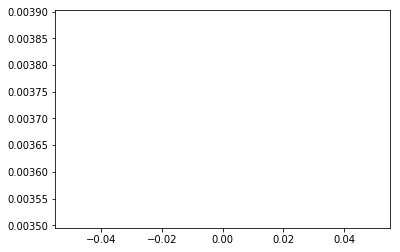

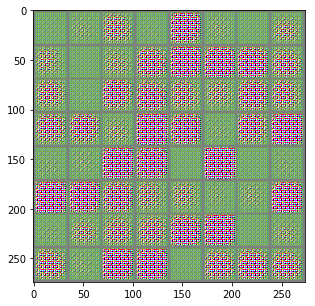

  1%|          | 101/10000 [11:03<18:04:15,  6.57s/it]

torch.Size([100, 512, 2, 2])
torch.Size([100, 512, 2, 2])


KeyboardInterrupt: 

In [57]:
from tqdm import tqdm
G = Generator()
G.apply(weights_init)
D = Discriminator()
print(G)
if use_cuda:
    G.cuda()
    D.cuda()
optimizers = {
    'D': torch.optim.RMSprop(D.parameters(), lr=D_lr),
    'G': torch.optim.RMSprop(G.parameters(), lr=G_lr)
}
criterion = nn.BCELoss()
errs=[]
for epoch in tqdm(range(10000)):
    optimizers['G'].zero_grad()
    data=next(iter(G_loader))[0]
    if use_cuda:
        data=data.cuda()
    input_holder.resize_as_(data).copy_(data)
    y = D(Variable(data))
    noise_holder.resize_(data.size()[0], z_size, 1, 1).normal_(0, 1)
    noisev = Variable(noise_holder)
    fake_data = G(noisev)
    x = D(fake_data)
    W_xy=sinkhorn_loss(x,y,epsilon,batch_size,niter)
    W_xx=sinkhorn_loss(x,x,epsilon,batch_size,niter)
    W_yy=sinkhorn_loss(y,y,epsilon,batch_size,niter)
    Loss_G=2*W_xy-W_xx-W_yy
    Loss_G.backward(one)
    if use_cuda:
        errs.append(Loss_G.cpu().data[0])
    else:
        errs.append(Loss_G.data[0])
    optimizers['G'].step()

    if epoch % 100 == 0:
        if use_cuda:
            dd = utils.make_grid(fake_data.cpu().data[:64])
        else:
            dd = utils.make_grid(fake_data.data[:64])
        dd = dd.mul(0.5).add(0.5)
        vutils.save_image(dd, './results/Vuil_Sinkhorn_DC_%d.png'%(epoch))
        imshow(dd,'./results/Sinkhorn_DC_%d.png'%(epoch))
        plt.plot(errs)
        plt.savefig('./results/Sinkhorn_DC_loss.png')